<a href="https://colab.research.google.com/github/yenlung/Deep-Learning-Basics/blob/master/colab02c%20%E7%94%A8%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92%E6%89%93%E9%80%A0%E5%85%AB%E5%93%A5%E8%BE%A8%E8%AD%98AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

台灣最常見的八哥有 (土) 八哥、白尾八哥及家八哥三種。我們來挑戰每種八哥只用三張照片, 看能不能打造一個神經網路學會辨識這三種八哥。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### 1. 讀入八哥資料圖檔

這裡把在 GitHub 上 `myna.zip` 的八哥照片集讀進來。

In [3]:
!wget --no-check-certificate \
    https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/myna.zip \
    -O /content/myna.zip

--2025-11-26 01:40:33--  https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/myna.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/myna.zip [following]
--2025-11-26 01:40:34--  https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/myna.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 964098 (942K) [application/zip]
Saving to: ‘/content/myna.zip’

/content/myna.zip   100%[===================>] 941.50K  --.-KB/s    in 0.05s   

2025-11-26 01:40:34 (19.5 MB/s) - ‘/content/myna.zip’ saved [964098/964098]



In [4]:
import os
import zipfile

local_zip = '/content/myna.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

大家在處理照片時，常會想，要怎麼標記呢? 其實可以像這樣子: 有三個類別, 就用三個資料夾存, 每個資料夾裡的照片讀出來, 就用 0, 1, 2 來標記!

### 2. 把八哥照片轉成訓練資料


In [5]:
base_dir = '/content/'

In [6]:
myna_folders = ['crested_myna', 'javan_myna', 'common_myna']

我們可以列出在某個資料夾的檔名! 比方說土八哥是這樣。

In [7]:
thedir = base_dir + myna_folders[0]
os.listdir(thedir)

['crested_myna03.jpg', 'crested_myna01.jpg', 'crested_myna02.jpg']

做成輸入 (data)、輸出 (target)。

In [8]:
data = []
target = []

for i in range(3):
    thedir = base_dir + myna_folders[i]
    myna_fnames = os.listdir(thedir)
    for myna in myna_fnames:
        img = load_img(thedir + '/' + myna, target_size = (256,256))
        x = img_to_array(img)
        data.append(x)
        target.append(i)


In [9]:
data = np.array(data)

我們選張八哥圖來看看。

In [10]:
len(data)

23

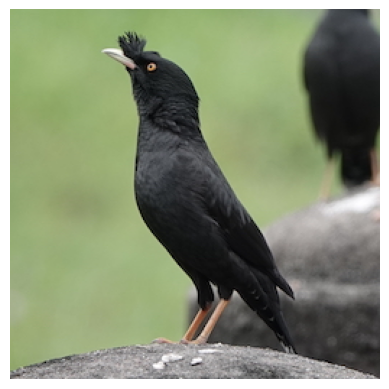

In [11]:
n=1
plt.axis('off')
plt.imshow(data[n]/255);

看來沒有什麼意外, 就是個鳥圖。我們用 ResNet 的預處理再看一次。

In [12]:
x_train = preprocess_input(data)

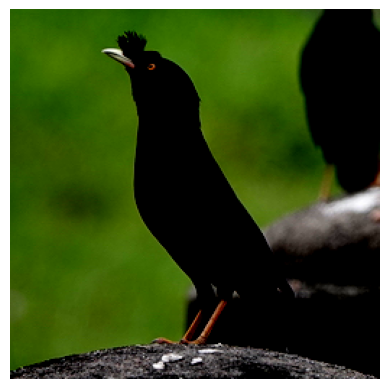

In [13]:
plt.axis('off')
plt.imshow(x_train[n]);

一個答案就是 0, 1, 2 其中一個數字。

In [14]:
target[n]

0

做 one-hot enconding。

In [15]:
y_train = to_categorical(target, 3)

In [16]:
y_train[n]

array([1., 0., 0.])

### 3. 用 ResNet50 打造我們的神經網路

ResNet50 是 2015 ImageNet 的冠軍, 我們用第二版來試試。原本 ImageNet 是做了 1,000 個類別的圖形辨識。我們想直接用來辨識八哥, 就是把最後一層 (通常就 1,000 個輸出的 dense 層) 砍掉 (`include_top=False`), 然後換我們的就好。

再來我們可以把每個 filter 的結果做個大總合, 例如算每個 filter 計分板的總平均 (global avg pooling), 這本來該我們自己做, 但是 `tf.Keras` 是善良無比的幫我們做好。只要下個參數 `pooling="avg"`)。

In [17]:
resnet = ResNet50V2(include_top=False, pooling="avg")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


我們是遷移式學習, 原本 ResNet 的部份我們當然沒有重新訓練的意思。於是就設這邊不需要訓練。

In [18]:
resnet.trainable = False

再來就是正式打造我們遷移學習版的函數學習機! 可以發現我們只是加入了最後一層...

In [19]:
model = Sequential()

In [20]:
model.add(resnet)

In [21]:
model.add(Dense(3, activation='softmax'))

#### 組裝我們的函數學習機

這裡我們用分類時非常標準的 `categorical_crossentropy`, 順便試試有名的 `adam` 學習法。

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### 欣賞我們的神經網路

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,570,947 (89.92 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

我們可以發現原來有超過兩千萬個參數, 經我們偷來, 不是, 借來以後, 只有 6,147 個參數要調。

### 4. 訓練 fit

這裡我們全部的資料也只有 23 筆, 所以 `batch_size` 就選擇 23 了...

In [24]:
model.fit(x_train, y_train, batch_size=23, epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.3043 - loss: 1.2813
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5652 - loss: 0.9791
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6957 - loss: 0.8395
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6087 - loss: 0.7987
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6087 - loss: 0.7698
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6087 - loss: 0.7199
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6087 - loss: 0.6506
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6522 - loss: 0.5735
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7826 - loss: 0.5003
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8261 - loss: 0.4386


### 5. 預測

對了, 為何這次我們沒有切測試一一資料呢? 那是因為畢竟我們每張八哥沒多少照片...

In [25]:
y_predict = np.argmax(model.predict(x_train), -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [26]:
y_predict

array([0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

好奇的話比較一下正確答案。

In [27]:
target

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

#### 三種八哥的 `labels`

In [28]:
labels = ["土八哥", "白尾八哥", "家八哥"]

### 6. 用 `gradio` 打造八哥辨識 web app!

In [29]:
!pip install gradio

In [30]:
import gradio as gr

注意現在主函數和我們做辨識 Cooper 的例子很像, 只是現在我們只有三個種類。而且是我們的 `model`!

In [43]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import preprocess_input

def classify_image(inp):
  # inp will be a numpy array with shape (H, W, 3) from gr.Image
  # Resize the image to (256, 256)
  img_resized_tensor = tf.image.resize(inp, (256, 256))
  # Convert the EagerTensor back to a NumPy array and add a batch dimension
  img_for_preprocess = np.expand_dims(img_resized_tensor.numpy(), axis=0)

  processed_input = preprocess_input(img_for_preprocess)
  prediction = model.predict(processed_input).flatten()
  return {labels[i]: float(prediction[i]) for i in range(3)}

image = gr.Image(label="八哥照片")
label = gr.Label(num_top_classes=3, label="AI辨識結果")

In [44]:
gr.Interface(fn=classify_image, inputs=image, outputs=label,
             title="AI 八哥辨識機",
             description="我能辨識台灣常見的三種八哥: (土)八哥、家八哥、白尾八哥。快找張八哥照片來考我吧!").launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3f8c40c47ecb81f1c2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
